## OT - we want to use OT concept to find pairs btwn ctrl and treatment, then using VAE get the transformations. We adjust the latent space of the VAE to introduce hierarchy and get explainability of the perturbations

### Imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

import ot
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.preprocessing import QuantileTransformer

### Magics

In [3]:
GENE_PER_CELL_BINNING = False
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 5000

### Step 0

In [4]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [5]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{0, 1, 2, 3}


In [6]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=True)

In [7]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

In [8]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [9]:
gene_num_map = ['ctrl']
y_processed = []

for rec in tqdm(y):
    y_processed.append([])
    comps = rec.split('+')
    for c in comps:
        if c not in gene_num_map:
            gene_num_map.append(c)
        y_processed[-1].append(gene_num_map.index(c))
    if len(y_processed[-1])<2:
        y_processed[-1].append(gene_num_map.index('ctrl'))

100%|██████████| 91205/91205 [00:00<00:00, 281298.92it/s]


In [10]:
def pair_records_optimal_transport(set1, set2):
    """
    Pairs records from set1 with records from set2 using the optimal transport concept.
    Records from set2 can be used multiple times if needed.

    Args:
    - set1 (np.ndarray): First 2D array of records (shape: n1 x features).
    - set2 (np.ndarray): Second 2D array of records (shape: n2 x features).

    Returns:
    - pairs (list of tuples): List of index pairs (i, j) where i is the index
      from set1 and j is the index from set2 that are paired.
    """

    # Ensure the inputs are numpy arrays
    set1 = np.array(set1)
    set2 = np.array(set2)

    # Compute the cost matrix (Euclidean distance between records)
    cost_matrix = ot.dist(set1, set2, metric='euclidean')

    # Compute the optimal transport plan using linear programming
    n1, n2 = set1.shape[0], set2.shape[0]
    a = np.ones(n1) / n1  # uniform distribution on set1
    b = np.ones(n2)  # flexible distribution on set2

    # Normalize b to sum to the same total mass as a
    b = b / b.sum() * a.sum()

    transport_plan = ot.emd(a, b, cost_matrix)

    # Extract pairs based on the transport plan
    pairs = []
    for i in range(n1):
        j = np.argmax(transport_plan[i])
        pairs.append((i, j))

    return pairs

    
# Example usage
set1 = np.random.rand(20, 5000)  # 100 records with 5000 features each
set2 = np.random.rand(100, 5000)  # 100 records with 5000 features each

pairs = pair_records_optimal_transport(set1, set2)
print(pairs)

[(0, 1), (1, 22), (2, 67), (3, 36), (4, 4), (5, 2), (6, 8), (7, 6), (8, 15), (9, 19), (10, 7), (11, 25), (12, 16), (13, 3), (14, 10), (15, 12), (16, 0), (17, 23), (18, 32), (19, 5)]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

In [12]:
def vae_data_prep(X, y):
    global lol
    # Convert list of lists to a set of tuples to find unique classes
    unique_classes = set(tuple(sorted(yi)) for yi in y)
    
    output_X = []
    output_Y = []
    labels = []
    
    # Convert y to a list of tuples for easier comparison
    y_tuples = [tuple(sorted(yi)) for yi in y]
    
    for c in tqdm(unique_classes):
        
        set1_indices = [i for i, yi in enumerate(y_tuples) if yi == c]
        set2_indices = [i for i, yi in enumerate(y_tuples) if yi == (0,0)]
        
        set1 = X[set1_indices]
        set2 = X[set2_indices]
        
        pairs = pair_records_optimal_transport(set1, set2)
        lol.extend(set2_indices)
        
        for p in pairs:
            output_X.append(set2[p[1]])
            output_Y.append(set1[p[0]])
            labels.append(c)
    
    output_X = np.array(output_X)
    output_Y = np.array(output_Y)
    
    return output_X, output_Y, labels

In [13]:
global lol 
lol = []
_, _, _ = vae_data_prep(X_val, y_val)

100%|██████████| 237/237 [00:05<00:00, 40.90it/s]


In [14]:
first = [i[0] for i in lol]
second = [i[1] for i in lol]

TypeError: 'int' object is not subscriptable

In [ ]:
len(dict(Counter(lol)).values())

In [ ]:
len(lol)

In [ ]:
first[-1]

In [15]:
X_trainv, Y_trainv, labels_trainv = vae_data_prep(X_train, y_train)
X_valv, Y_valv, labels_valv = vae_data_prep(X_val, y_val)
X_testv, Y_testv, labels_testv = vae_data_prep(X_test, y_test)

 27%|██▋       | 63/237 [00:18<00:41,  4.15it/s]/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 237/237 [00:19<00:00, 12.24it/s]


In [16]:
pca = PCA(n_components=0.99)
X_train_r = X_trainv #pca.fit_transform(X_trainv)
X_val_r = X_valv#pca.transform(X_valv)
X_test_r = X_testv#pca.transform(X_testv)

In [17]:
Y_train_r = Y_trainv#pca.transform(Y_trainv)
Y_val_r = Y_valv#pca.transform(Y_valv)
Y_test_r = Y_testv#pca.transform(Y_testv)

In [18]:
# qt = QuantileTransformer(output_distribution='normal',random_state=42,)
# qt.fit(X_trainv)
# X_train_r = qt.transform(X_trainv)
# X_test_r = qt.transform(X_testv)
# X_val_r = qt.transform(X_valv)

# Y_train_r = qt.transform(Y_trainv)
# Y_test_r = qt.transform(Y_testv)
# Y_val_r = qt.transform(Y_valv)

In [19]:
# model = LGBMClassifier(verbose=-1, n_jobs=10)
# model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc_mu',    callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(1)
#     ])

In [20]:
device = 'cuda:0'

In [776]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(VAE, self).__init__()

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.encoder = self.build_encoder(input_dim, latent_dim, hidden_dims)
        self.decoder = self.build_decoder(latent_dim, input_dim, hidden_dims)
        
        # Initialize the thresholds for the splits
        self.thresholds = torch.randn(latent_dim//2-1).to(device)

    def build_encoder(self, input_dim, latent_dim, hidden_dims):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.4)) 
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def build_decoder(self, latent_dim, output_dim, hidden_dims):
        layers = []
        hidden_dims.reverse()
        for h_dim in hidden_dims:
            layers.append(nn.Linear(latent_dim, h_dim))
            layers.append(nn.ReLU())
            latent_dim = h_dim
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def mask_v2(self, z):
        # Create a binary mask
        binary_mask = torch.zeros_like(z[:,:128])
        
        # Iterate over each feature in the latent space
        for i in range(z[:,:128].size(1)):
            # If the feature value is greater than the threshold, set the mask value to 1
            binary_mask[:, i] = (z[:, i] > self.thresholds[i]).float()
            
            # For odd indices, mask if parent (i//2) is zero
            if i % 2 != 0:
                binary_mask[:, i] *= (binary_mask[:, i//2] == 0).float()
            # For even indices, mask if parent (i//2 - 1) is > 0
            elif i % 2 == 0 and i > 0:
                binary_mask[:, i] *= (binary_mask[:, i//2 - 1] > 0).float()
        
        # Apply the binary mask to the latent space
        z_masked = binary_mask * z[:,:128]
        
        return torch.cat([z_masked, z[:,128:]], axis=1)


    def mask_v1(self, z):
        mask = (z[:,:128] > self.thresholds).float()
        for i in range(1, len(mask)):
            if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                mask[i] *= mask[i//2 - 1]
            else:  # For odd indices, mask if parent (i//2) is masked
                mask[i] *= mask[i//2]
                
        return torch.cat([mask * z[:,:128], z[:,128:]], axis=1)
    
    def mask(self,z):
        mask = (z[:, :127] > self.thresholds).float()
        #mask[:, 0] = 1
        for level in range(1, 7):
            nonzero = torch.zeros(z.shape[0]).to(device)
            for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
                #
                if (nonzero > 0).any():
                    mask[nonzero > 0, i] = 0
    
                parent_index = i // 2
                if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index - 1]
                else:  # For odd indices, mask if parent (i//2) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index]
                
                nonzero += mask[:, i]
                
            if (nonzero == 0).any():
                mask[nonzero == 0, i] = 1

        return torch.cat([mask , z[:,127:]], axis=1) #* (z[:,:127])
    
    
    def mask_v11(self, z):
        mask = (z[:,:128] > self.thresholds).float()
        for level in range(6): 
            nonzero = False
            for i in range(2**level, 2**(level+1)):
                
                if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                    mask[i] *= mask[i//2 - 1]
                else:  # For odd indices, mask if parent (i//2) is masked
                    mask[i] *= mask[i//2]
                if mask[i] > 0:
                    nonzero = True
            if nonzero==False:
                mask[i] = 1
            else:
                nonzero = False
                    
        return torch.cat([mask * z[:,:128], z[:,128:]], axis=1)

    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, perturbs = []):
        mu, logvar = self.encode(x.to(device))
        z = self.reparameterize(mu, logvar)
        z_p = z.clone()

        z[:,:127] *= 0
        z_p = self.mask(z_p)  # Apply the mask before decoding
        
        # Perturbation introduced at the latent space level
        for pert_n in perturbs:
            perturbs_tensor = pert_n.to(device)
    
            non_zero_batch_indices = perturbs_tensor.nonzero(as_tuple=False)
            dim_pert = perturbs_tensor[non_zero_batch_indices]
            dim_pert = dim_pert.type(torch.int16).cpu().numpy()
            z_p[non_zero_batch_indices, dim_pert + 128] += 500
        
        pert_x = self.decode(z_p)
        recon_x = self.decode(z)
        
        return pert_x, recon_x, mu, logvar

        
def vae_loss(pert_x, y, recon_x, x, mu, logvar):
    x = x.to(device)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    pert_loss = nn.functional.mse_loss(pert_x, y, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar[:,128:] - mu[:,128:].pow(2) - logvar[:,128:].exp())
    return recon_loss, pert_loss, kl_loss #

def train_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        total_train_recon_loss = 0
        total_train_pert_loss = 0
        total_train_kl_loss = 0
        for batch_ctrl, batch_pert, pert_labels in train_loader:
            optimizer.zero_grad()
            batch_ctrl = batch_ctrl.to(device)
            batch_pert = batch_pert.to(device)
                        
            pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
            
            z = model.reparameterize(mu, logvar)
            recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar)
            loss = recon_loss + pert_loss + kl_loss
            loss.backward()
            optimizer.step()
            total_train_recon_loss += recon_loss.item()
            total_train_pert_loss += pert_loss.item()
            total_train_kl_loss += kl_loss.item()
        
        avg_train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
        avg_train_pert_loss = total_train_pert_loss / len(train_loader.dataset)
        avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
        train_losses.append((avg_train_recon_loss, avg_train_pert_loss, avg_train_kl_loss))
        
        model.eval()
        total_val_recon_loss = 0
        total_val_pert_loss = 0
        total_val_kl_loss = 0
        with torch.no_grad():
            for batch_ctrl, batch_pert, pert_labels in val_loader:

                batch_ctrl = batch_ctrl.to(device)
                batch_pert = batch_pert.to(device)
                                
                pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
                z = model.reparameterize(mu, logvar)
                recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar)
                total_val_recon_loss += recon_loss.item()
                total_val_pert_loss += pert_loss.item()
                total_val_kl_loss += kl_loss.item()
        
        avg_val_recon_loss = total_val_recon_loss / len(val_loader.dataset)
        avg_val_pert_loss = total_val_pert_loss / len(val_loader.dataset)
        avg_val_kl_loss = total_val_kl_loss / len(val_loader.dataset)
        val_losses.append((avg_val_recon_loss, avg_val_pert_loss, avg_val_kl_loss))
        
        #print(f'Epoch {epoch+1}, Train Recon Loss: {avg_train_recon_loss:.4f}, Train Pert Loss: {avg_train_pert_loss:.4f}, Train KL Loss: {avg_train_kl_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val Pert Loss: {avg_val_pert_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}')
        
        model.train()

        # Plotting the losses
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(10, 7))
        
        ax[0].plot([x[0] for x in train_losses], label='Train Recon Loss')
        ax[1].plot([x[1] for x in train_losses], label='Train Pert Loss')
        ax[2].plot([x[2] for x in train_losses], label='Train KL Loss')
        # Plot validation losses
        ax[0].plot([x[0] for x in val_losses], label=f'Val Recon Loss; Best: {np.argmin([x[0] for x in val_losses])}')
        ax[1].plot([x[1] for x in val_losses], label=f'Val Pert Loss; Best: {np.argmin([x[1] for x in val_losses])}')
        ax[2].plot([x[2] for x in val_losses], label=f'Val KL Loss; Best: {np.argmin([x[2] for x in val_losses])}')
        
        # Add legends
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        plt.show()
        # Add titles


In [777]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.labels[idx]


train_dataset = CustomDataset(X_trainv[:,:], Y_trainv[:,:], labels_trainv)
val_dataset = CustomDataset(X_valv[:,:], Y_valv[:,:], labels_valv)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

input_dim = X_trainv.shape[1]
latent_dim = 256
hidden_dims = [1024, 512,]
epochs = 800
learning_rate = 1e-3

vae = VAE(input_dim, latent_dim, hidden_dims).to(device)

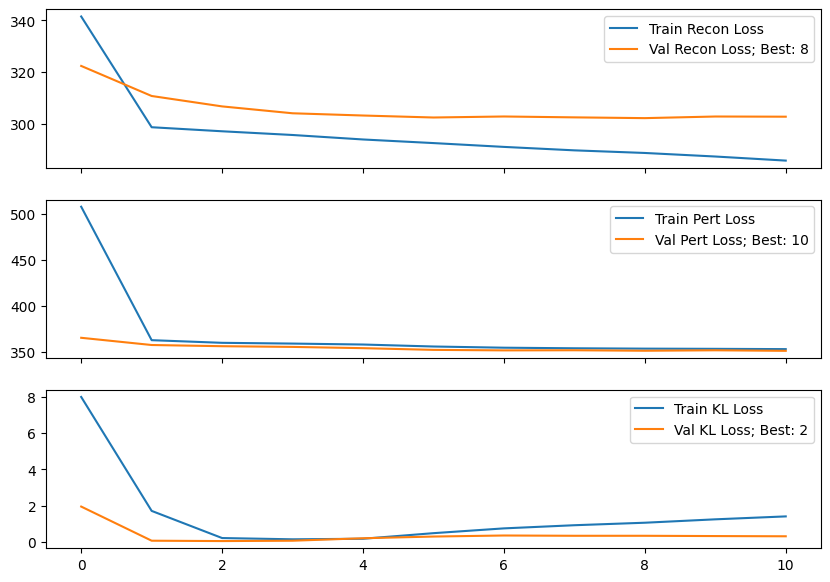

KeyboardInterrupt: 

In [778]:
train_vae(vae, train_loader, val_loader, epochs, learning_rate)

In [779]:
def mask(z, thresholds):
    mask = (np.array(z[:127]) > thresholds).astype(float)
    mask[0] = 1
    for level in range(1, 7):
        nonzero = 0
        for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
            if nonzero > 0:
                mask[i] = 0

            parent_index = i // 2
            if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                mask[i] *= mask[parent_index - 1]
            else:  # For odd indices, mask if parent (i//2) is masked
                mask[i] *= mask[parent_index]

            if mask[i] > 0:
                nonzero += 1

        if nonzero == 0:
            mask[i] = 1
            nonzero = 0
        else:
            nonzero = 0

    return mask


In [780]:
# For testing, you can run the model in evaluation mode
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        masked_z = vae.mask(z)[:,:127].cpu().numpy()
        break

In [781]:
for i in range(20):
    print(np.arange(127)[(masked_z>0)[i,:]])

[ 2  5 11 23 48 98]
[ 0  2  5 11 23 47 96]
[  0   1   6  14  29  59 126]
[  0   2   5  11  23  62 126]
[  0   1   3  14  29  59 126]
[  0   1   6  14  29  59 126]
[  2   5  11  23  62 126]
[  2   5  11  23  62 126]
[  2   6  13  30  61 126]
[  0   2   5  11  23  62 125]
[ 2  5 11 23 48 98]
[  0   1   6  13  28  57 116]
[  2   5  11  24  49 100]
[  0   1   6  13  30  62 126]
[  2   5  11  24  62 125]
[  2   5  11  23  62 126]
[ 0  2  5 11 23 47 96]
[  2   5  11  23  62 126]
[  0   1   3  14  29  59 126]
[  0   2   5  11  23  62 126]


In [786]:
paths = []
distance_mtx = np.zeros((512,512))
for i in tqdm(range(512)):
    for j in range(512):
        inds1 = np.arange(127)[(masked_z>0)[i,:]]
        inds2 = np.arange(127)[(masked_z>0)[j,:]]
        distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))/(min(len(inds1),len(inds2))+1)
        #distance_mtx[i,j] = 2*len(set(inds1.tolist()).intersection(set(inds2.tolist())))/(len(inds1)+len(inds2)+1)

100%|██████████| 512/512 [00:03<00:00, 133.29it/s]


In [787]:
distance_mtx[11:39,11:39].mean(), distance_mtx[:11,:11].mean()

(0.33705357142857145, 0.41912632821723733)

In [788]:
distance_mtx.mean()

0.32628229686192095

<Axes: >

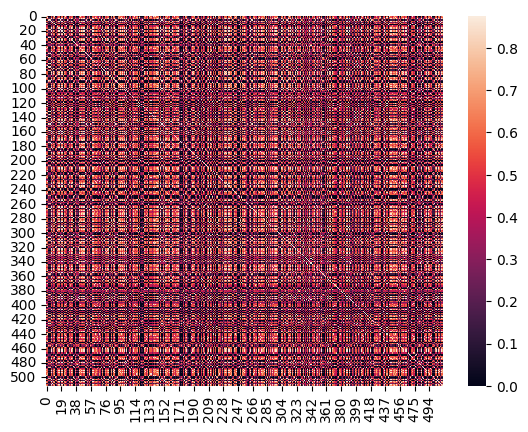

In [789]:
import seaborn as sns
sns.heatmap(distance_mtx)

## Let's get a UMAP of this and see whether clusters resemble the perturbations

In [790]:
# For testing, you can run the model in evaluation mode
vae.eval()
masked_z = []
first_all = []
second_all = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        t_masked_z = vae.mask(z)[:,:127].cpu().numpy()
        masked_z.append(t_masked_z)
        first_all.extend(pert_labels[0].cpu().numpy()) 
        second_all.extend(pert_labels[1].cpu().numpy()) 

In [791]:
z = np.vstack(masked_z)

In [792]:
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))

unique_colors = np.unique(colors)
color_map = {color: i for i, color in enumerate(unique_colors)}

# Convert colors to numeric values
numeric_colors = np.array([color_map[color] for color in colors])

In [793]:
import umap.umap_ as umap

# Generate a random distance matrix (replace with your actual data)
#distance_mtx = np.random.rand(100, 100)

# Generate arbitrary colors (replace with your actual colors)
#colors = np.random.choice(['red', 'green', 'blue', 'yellow'], size=100)

# Apply UMAP
reducer = umap.UMAP(n_components=2,)
embedding = reducer.fit_transform(z[:,:64])

In [794]:
#numeric_colors[numeric_colors>10] = -1

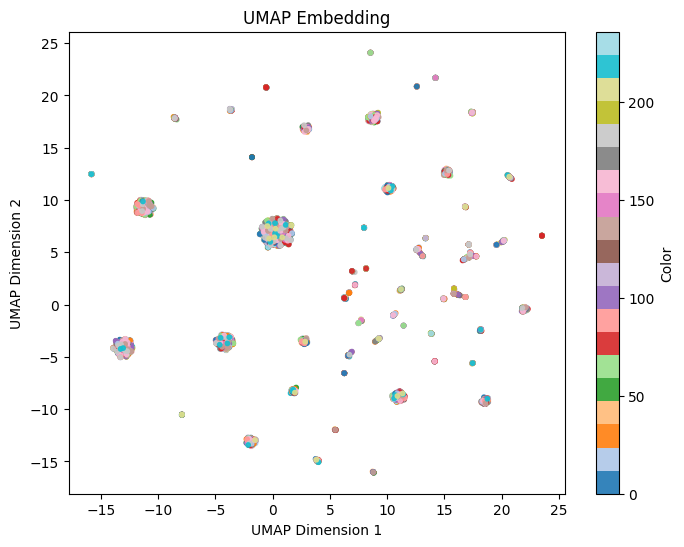

In [795]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=numeric_colors, cmap='tab20', s=10,alpha=0.9)
plt.title("UMAP Embedding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Color")
plt.show()

In [52]:
zs = []
labels0 = []
labels1 = []
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in tqdm(val_loader):
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        labels0.append(pert_labels[0].numpy())
        labels1.append(pert_labels[1].numpy())
        zs.append(z.detach().cpu().numpy())
        break

  0%|          | 0/25 [00:00<?, ?it/s]


In [53]:
zsnp = np.concatenate(zs)

In [54]:
labels0 = np.concatenate(labels0)
labels1 = np.concatenate(labels1)

In [55]:
labels0[0], labels1[0]

(9, 70)

In [56]:
labels0[-2], labels1[-2]

(0, 69)

In [57]:
np.argsort(abs(pert_x.detach().cpu().numpy() - recon_x.detach().cpu().numpy()), axis=1)

array([[3623, 2762, 4994, ..., 3687, 2630, 2158],
       [3623,  831, 4994, ..., 4410, 3687, 2158],
       [ 893,  831, 3623, ..., 2630, 4703, 2158],
       ...,
       [ 940, 4027, 4884, ..., 4410, 2061, 2158],
       [3719, 4884, 1457, ..., 4410, 2061, 2158],
       [ 893, 3623, 4994, ..., 4635, 1685, 1684]])

### Manual Explore

In [58]:
batch_pert[0,920], batch_ctrl[0,920]

(tensor(0.6172), tensor(0.))

In [60]:
pert_x[0,920],recon_x[0,920]

(tensor(0.1721, device='cuda:0'), tensor(0.0034, device='cuda:0'))

In [61]:
gene_num_map[9], gene_num_map[69], gene_num_map[70]

('TGFBR2', 'BPGM', 'SAMD1')

In [62]:
adata.var.iloc[[4977,2158]].gene_name

gene_id
ENSG00000182871    COL18A1
ENSG00000158578      ALAS2
Name: gene_name, dtype: category
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [63]:
adata.var.iloc[[3687,2158]].gene_name

gene_id
ENSG00000206172     HBA1
ENSG00000158578    ALAS2
Name: gene_name, dtype: category
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [64]:
pert_x[0,920],recon_x[0,920]

(tensor(0.1721, device='cuda:0'), tensor(0.0034, device='cuda:0'))

In [ ]:
gene_num_map[9], gene_num_map[70]

In [ ]:
adata.var.iloc[[3687,2158]].gene_name